In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_log_error, r2_score
from matplotlib.ticker import ScalarFormatter #to change scientific format

# Functions
def format_y_axis():    
    ax = plt.gca()
    y_format = ScalarFormatter()
    y_format.set_scientific(False)
    ax.yaxis.set_major_formatter(y_format)
    
def format_y_axis_subplot(ax):    
    y_format = ScalarFormatter()
    y_format.set_scientific(False)
    ax.yaxis.set_major_formatter(y_format)


In [2]:
# Databases
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
train_by_date = train_df.groupby(by = 'date').sum()
test_by_date = test_df.groupby(by = 'date').sum()
transactions_by_date = transactions.groupby(by = 'date').sum()

In [15]:
train_by_date.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,1586871,49005,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,2511.618999,0
2013-01-02,4762395,49005,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,496092.417944,0
2013-01-03,7937919,49005,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,361461.231124,0
2013-01-04,11113443,49005,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,354459.677093,0
2013-01-05,14288967,49005,AUTOMOTIVEBABY CAREBEAUTYBEVERAGESBOOKSBREAD/B...,477350.121229,0


In [3]:
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [6]:
# Training data high level
print('nr of diff stores', train_df['store_nbr'].nunique())
print('nr of diff product category', train_df['family'].nunique())
print('first date:', train_df['date'].min(), 'last date:', train_df['date'].max() )
print('max nr of products in the category promoted:', train_df['onpromotion'].max() )

nr of diff stores 54
nr of diff product category 33
first date: 2013-01-01 00:00:00 last date: 2017-08-15 00:00:00
max nr of products in the category promoted: 741


In [7]:
# Test data high level

print('nr of diff stores', test_df['store_nbr'].nunique())
print('nr of diff product category', test_df['family'].nunique())
print('first date:', test_df['date'].min(), 'last date:', test_df['date'].max() )
print('max nr of products in the category promoted:', test_df['onpromotion'].max() )

nr of diff stores 54
nr of diff product category 33
first date: 2017-08-16 00:00:00 last date: 2017-08-31 00:00:00
max nr of products in the category promoted: 646


In [9]:
# Check Missing Dates
tdelta = timedelta( days = 1)

first_date = train_df['date'].min().date()
last_date = train_df['date'].max().date()
print(last_date - first_date + tdelta)
print('different days:', train_df['date'].nunique())

# Missing dates 
list = [train_by_date.index[0]]
for i,  date in enumerate(train_by_date.index[1:]):
    list.append(date)
    if list[i+1] != list[i] + tdelta:
        print(date-tdelta)

1688 days, 0:00:00
different days: 1684
2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


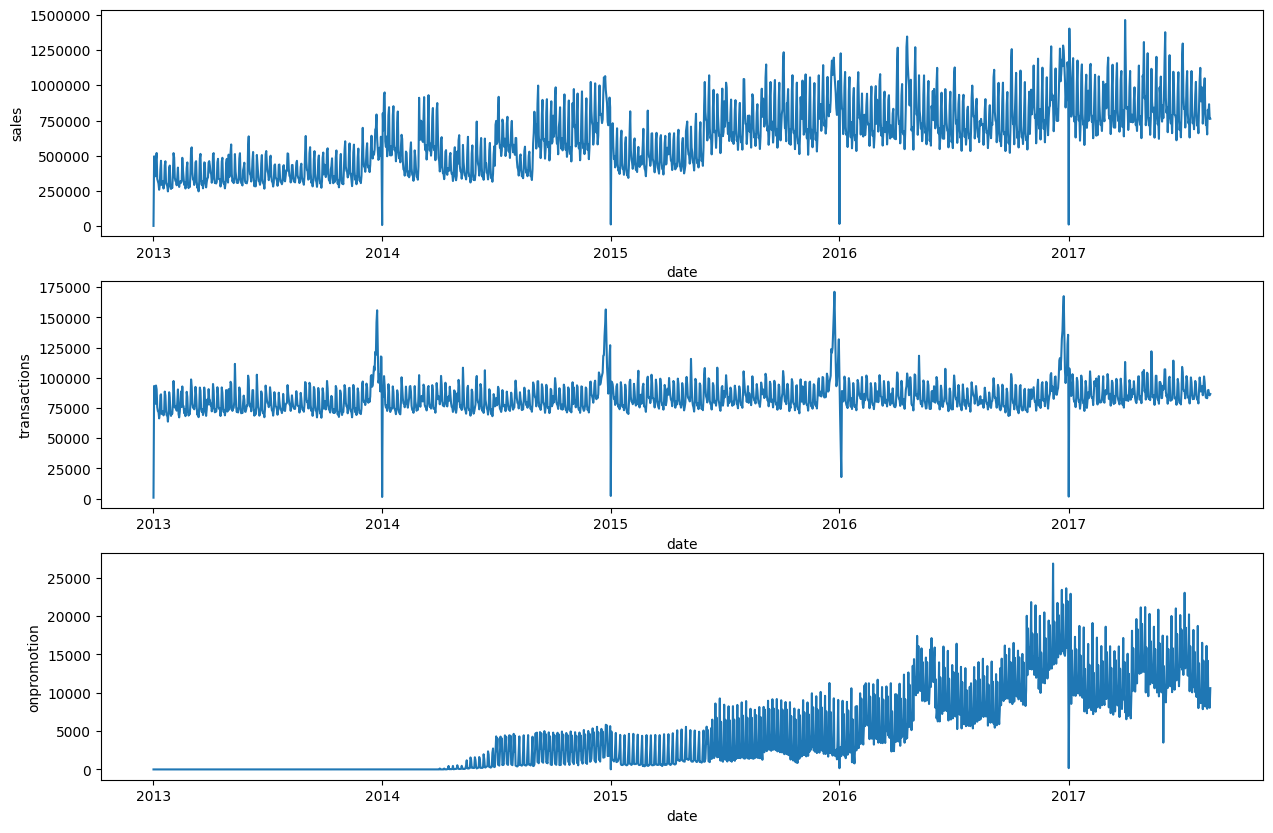

In [3]:
# Total sales and promotions
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,10))
sns.lineplot(data = train_by_date, x = 'date', y = 'sales', ax= ax1)
sns.lineplot(data = transactions_by_date, x = 'date', y = 'transactions', ax= ax2)
sns.lineplot(data = train_by_date, x = 'date', y = 'onpromotion', ax= ax3)
format_y_axis_subplot(ax1)

In [3]:
# Adding features to the data frame
complete_date_range = pd.DataFrame()
complete_date_range['date'] = pd.date_range(start=train_df['date'].min(), end=test_df['date'].max(), freq='D')
complete_date_range['time'] = complete_date_range.index
train_by_date = pd.merge(train_by_date, complete_date_range, how = 'left', on ='date')

train_by_date['lag7'] = train_by_date['sales'].shift(7)
train_by_date['lag1'] = train_by_date['sales'].shift(1)
train_by_date['lag14'] = train_by_date['sales'].shift(14)
train_by_date.dropna(inplace= True)

train_by_date['square'] = [n**2 for n in train_by_date.time]

train_by_date['weekday'] = [n.isoweekday() for n in train_by_date['date']]
train_by_date = pd.get_dummies(train_by_date, columns=['weekday'])

test_by_date = pd.merge(test_by_date, complete_date_range, how = 'left', on ='date')



<Axes: xlabel='sales', ylabel='lag14'>

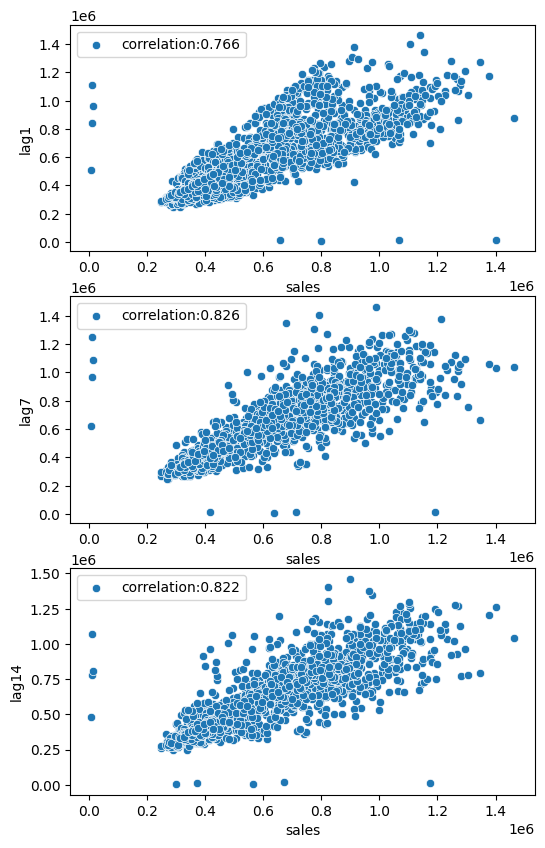

In [4]:
# The relationship between the sales and the 3 lags
corr_lag1 = train_by_date['sales'].corr(train_by_date['lag1']).round(3)
corr_lag7 = train_by_date['sales'].corr(train_by_date['lag7']).round(3)
corr_lag14 = train_by_date['sales'].corr(train_by_date['lag14']).round(3)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,10))
sns.scatterplot(data=train_by_date, x='sales', y='lag1', ax = ax1, label= f'correlation:{corr_lag1}')
sns.scatterplot(data=train_by_date, x='sales', y='lag7', ax = ax2, label= f'correlation:{corr_lag7}')
sns.scatterplot(data=train_by_date, x='sales', y='lag14', ax = ax3, label= f'correlation:{corr_lag14}')

In [4]:
def run_rgr(*args, vis = 'no', rtr_pred = 'no'):
    #  preparing_data sets
    arg_list = list(args)
    X_train = train_by_date[arg_list][:-30].values
    y_train = train_by_date['sales'][:-30].values.reshape(-1, 1)
    X_CV = train_by_date[arg_list][-30:-15].values  
    y_CV = train_by_date['sales'][-30:-15].values.reshape(-1, 1)
    X_test = train_by_date[arg_list][-15:].values
    
    # scaling -  get back the same result with scaling so I am not using it
    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train = scaler.transform(X_train)
    # X_CV  = scaler.transform(X_CV)
    # X_test  = scaler.transform(X_test)


    rgr = linear_model.LinearRegression()
    rgr.fit(X_train, y_train)
    pred_CV = rgr.predict(X_CV)
    pred_train = rgr.predict(X_train)
    pred_test = rgr.predict(X_test)
    if rtr_pred == 'train':
        return pred_train
    elif rtr_pred == 'CV':
        return pred_CV
    elif rtr_pred == 'test':
        return pred_test
    else:
        print('coef:',rgr.coef_.round(2), 'intercept:', rgr.intercept_.round(2))
        print("Mean squared log error CV: %.4f" % mean_squared_log_error(y_CV, pred_CV))
        print("R2 CV (r2_score method): %.4f" % r2_score(y_CV, pred_CV))
        print("R2 Train (r2_score method): %.4f" % r2_score(y_train, pred_train))
        if vis == 'yes':
            format_y_axis()
            return plt.plot(X_CV[:,0], y_CV), plt.plot(X_CV[:,0], pred_CV), plt.title('CV_plot')

In [30]:


a = np.empty((0,1))
b = run_rgr('time', rtr_pred = 'test')
x = np.concatenate((a,b))
b.shape

(15, 1)

In [ ]:
np.array()

coef: [[166891.31]] intercept: [636451.88]
Mean squared log error CV: 0.0366
R2 CV (r2_score method): -0.4625
R2 Train (r2_score method): 0.5104


([<matplotlib.lines.Line2D at 0x14596e40150>],
 Text(0.5, 1.0, 'CV_plot'))

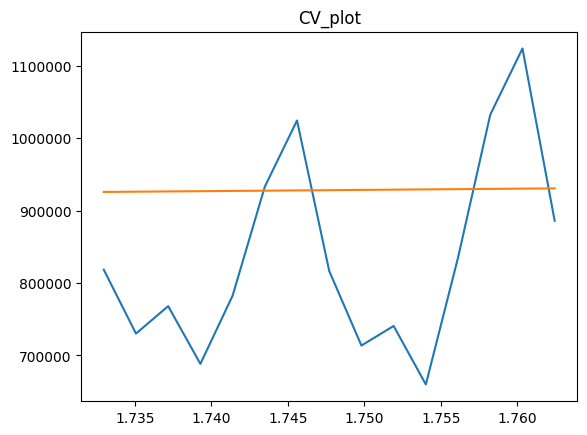

In [7]:
# Simple linear regression w time feature wo/lag
run_rgr('time', vis = 'yes')

coef: [[ 80250.32 121294.32]] intercept: [636451.88]
Mean squared log error CV: 0.0232
R2 CV (r2_score method): 0.0395
R2 Train (r2_score method): 0.6425


([<matplotlib.lines.Line2D at 0x145a7e63fd0>],
 Text(0.5, 1.0, 'CV_plot'))

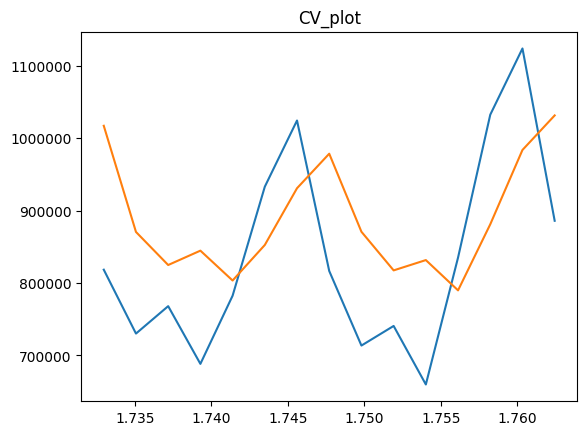

In [8]:
# adding lag1 shifts the peak
run_rgr('time', 'lag1', vis ='yes')

coef: [[ 59161.79 150234.62]] intercept: [636451.88]
Mean squared log error CV: 0.0068
R2 CV (r2_score method): 0.7322
R2 Train (r2_score method): 0.7114


([<matplotlib.lines.Line2D at 0x145a7ea6ed0>],
 Text(0.5, 1.0, 'CV_plot'))

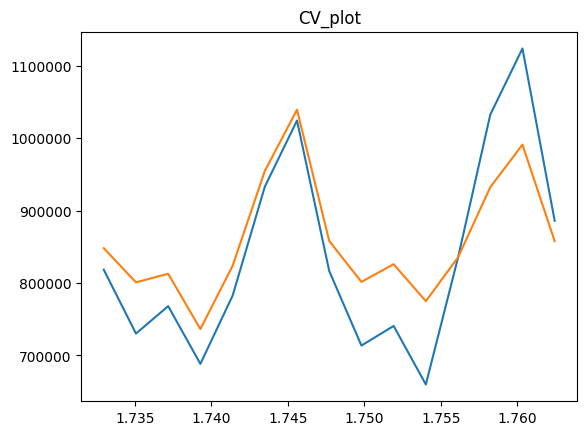

In [9]:
# adding lag7 - the best of the lags
run_rgr('time', 'lag7', vis ='yes')

In [10]:
#using lag 14 alone brings us close too
run_rgr('time', 'lag14')

coef: [[ 60703.3  148092.06]] intercept: [636451.88]
Mean squared log error CV: 0.0094
R2 CV (r2_score method): 0.6445
R2 Train (r2_score method): 0.7057


In [12]:
# using lag7 and lag14 gives us the best R CV score
run_rgr('time','lag7', 'lag14')

coef: [[36355.   93979.44 88064.74]] intercept: [636451.88]
Mean squared log error CV: 0.0045
R2 CV (r2_score method): 0.8170
R2 Train (r2_score method): 0.7523


transformed features 
 [[1.000000e+00 1.400000e+01 1.960000e+02]
 [1.000000e+00 1.500000e+01 2.250000e+02]
 [1.000000e+00 1.600000e+01 2.560000e+02]
 ...
 [1.000000e+00 1.685000e+03 2.839225e+06]
 [1.000000e+00 1.686000e+03 2.842596e+06]
 [1.000000e+00 1.687000e+03 2.845969e+06]]
quadratic model coefs: [[ 0.00000000e+00  5.04310977e+02 -9.34510569e-02]]


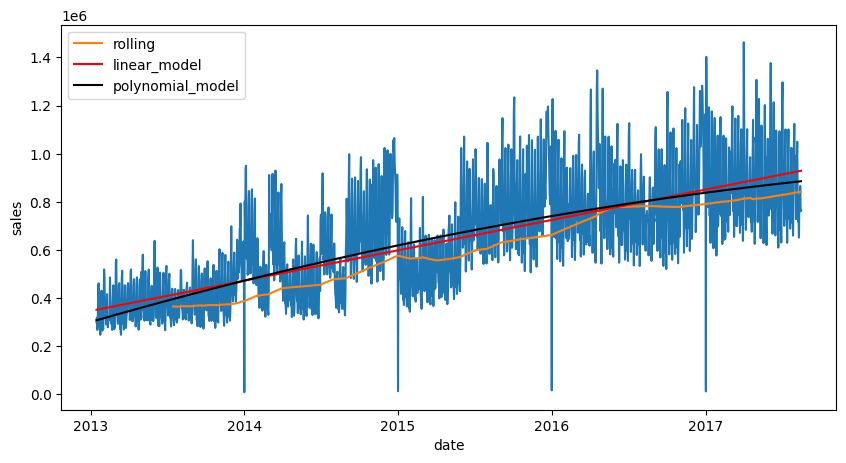

In [12]:
# The quadratic trend fits better the data a tiny bit though it can be hardly seen from the rolling average - 
# the rolling should give a clue what sort of polynomial we need

train_by_date['rolling'] = train_by_date['sales'].rolling(
    window=365,       # 365-day window
    # center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()  


poly = PolynomialFeatures(degree=2)
rgr = linear_model.LinearRegression()
rgr_poly = linear_model.LinearRegression()

X_train = train_by_date[['time']].values
X_train_poly = poly.fit_transform(train_by_date[['time']].values)

y_train = train_by_date['sales'].values.reshape(-1, 1)

rgr.fit(X_train, y_train)
rgr_poly.fit(X_train_poly, y_train)

pred = rgr.predict(X_train)
pred_poly = rgr_poly.predict(X_train_poly)

fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(data = train_by_date, x = 'date', y = 'sales', ax= ax1)
sns.lineplot(data = train_by_date, x = 'date', y = 'rolling', ax= ax1, label = 'rolling')
ax1.plot(train_by_date['date'], pred, color= 'r', label = 'linear_model')
ax1.plot(train_by_date['date'], pred_poly, color= 'black', label = 'polynomial_model')
ax1.legend()
print('transformed features \n', poly.fit_transform(train_by_date[['time']].values))
print('quadratic model coefs:', rgr_poly.coef_)

In [13]:
# adding squared time to fit trend - small improvement
run_rgr('time', 'lag7', 'lag14', 'square')

coef: [[ 1.1623e+02  4.0000e-01  3.7000e-01 -2.0000e-02]] intercept: [70124.88]
Mean squared log error CV: 0.0039
R2 CV (r2_score method): 0.8331
R2 Train (r2_score method): 0.7527


In [14]:
# trying with weekday gives poor R2 CV - overfits
run_rgr('time', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7')

coef: [[    351.33  -20576.27  -66704.32  -45322.07 -132545.75  -58566.77
   135332.14  188383.04]] intercept: [342933.41]
Mean squared log error CV: 0.0152
R2 CV (r2_score method): 0.4239
R2 Train (r2_score method): 0.7244


coef: [[ 2.436700e+02  2.600000e-01 -4.000000e-02  2.500000e-01 -1.159068e+04
  -3.276898e+04 -2.252467e+04 -6.681369e+04 -2.860944e+04  6.844545e+04
   9.386200e+04]] intercept: [150572.62]
Mean squared log error CV: 0.0035
R2 CV (r2_score method): 0.8580
R2 Train (r2_score method): 0.7784


([<matplotlib.lines.Line2D at 0x212b92ba850>],
 Text(0.5, 1.0, 'CV_plot'))

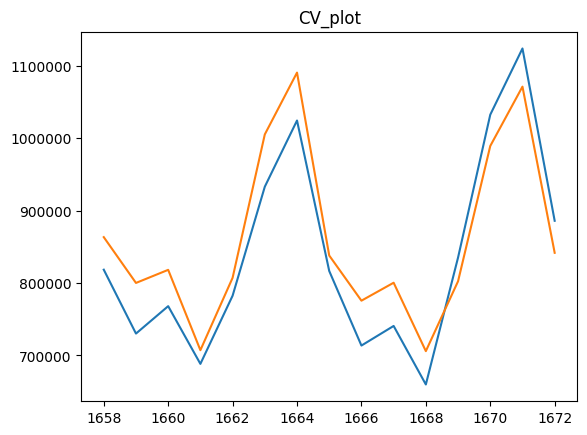

In [15]:
# weekdays improve lag 7-14-square estimation
run_rgr('time', 'lag7', 'square', 'lag14', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', vis = 'yes')

Predicting Residuals by XGBOOST

In [6]:
from xgboost import XGBRegressor

# final estimation from linear rgr
pred_train = run_rgr('time', 'lag7', 'lag14', 'square', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',rtr_pred='train')
pred_CV = run_rgr('time', 'lag7', 'lag14', 'square', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', rtr_pred='CV')


X_train = train_by_date[['time','lag14' ]][:-30].values
y_train = train_by_date['sales'][:-30].values.reshape(-1, 1)
X_CV = train_by_date[[ 'time', 'lag14']][-30:-15].values
y_CV = train_by_date['sales'][-30:-15].values.reshape(-1, 1)


# the residuals y
y_train_res = y_train - pred_train.reshape(-1, 1)
y_CV_res = y_CV - pred_CV.reshape(-1, 1)

xgb = XGBRegressor( )
xgb.fit(X_train, y_train_res)
pred_train_res = xgb.predict(X_train).reshape(-1, 1)
pred_CV_res = xgb.predict(X_CV).reshape(-1, 1)
print("R2 CV Residual: %.4f" % r2_score(y_CV_res, pred_CV_res))
print("R2 Train Residual: %.4f" % r2_score(y_train_res, pred_train_res))


R2 CV Residual: -0.1167
R2 Train Residual: 0.9017


In [7]:
# The final model's (linear regression + xgboost) Train and CV accuracy
pred_train_new = (pred_train + pred_train_res)
pred_CV_new = (pred_CV + pred_CV_res)
print('Final_models train R2', r2_score(y_train, pred_train_new).round(4))
print('Final_models CV R2', r2_score(y_CV, pred_CV_new).round(4))

Final_models train R2 0.9782
Final_models CV R2 0.8785


linear regr test R2 -0.2157836833780633


Text(0.5, 1.0, 'Linear_Test_plot')

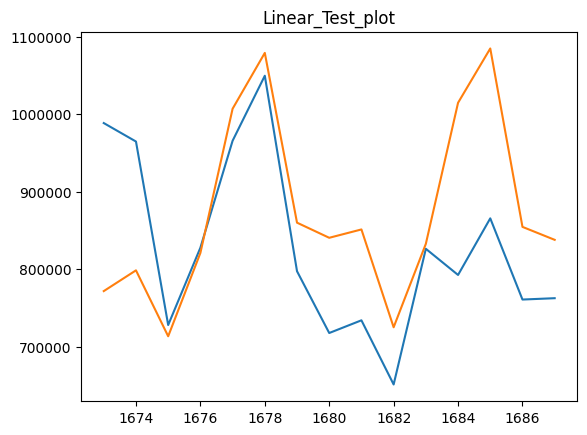

In [19]:
# Linear part test result
pred_test = run_rgr('time', 'lag7', 'lag14', 'square', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',rtr_pred='test')
y_test = train_by_date['sales'][-15:].values.reshape(-1, 1)
X_test = train_by_date[['time', 'lag7', 'lag14', 'square', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']][-15:].values
print('linear regr test R2', r2_score(y_test, pred_test))
format_y_axis()
plt.plot(X_test[:,0], y_test),
plt.plot(X_test[:,0], pred_test),
plt.title('Linear_Test_plot')

R2 Test Residual: -0.0324
Final_models test R2 -0.0951
Mean squared log error Test: 0.0191


Text(0.5, 1.0, 'Final_Test_plot')

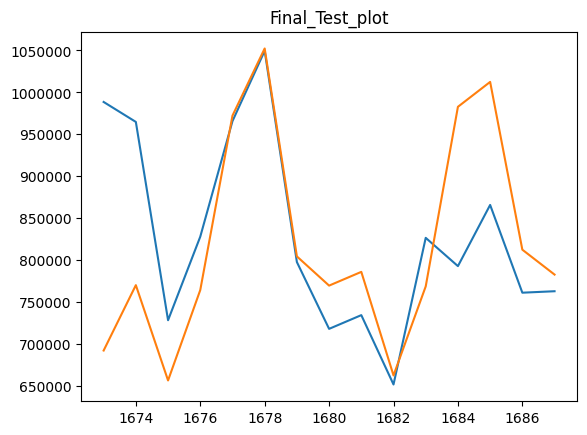

In [21]:
# FINAL TEST accuracy- added residual estimation for the test
X_train = train_by_date[['time','lag14' ]][:-30].values
y_train = train_by_date['sales'][:-30].values.reshape(-1, 1)
y_test = train_by_date['sales'][-15:].values.reshape(-1, 1)
X_test = train_by_date[['time','lag14',]][-15:].values

y_train_res = y_train - pred_train.reshape(-1, 1)
y_test_res = y_test - pred_test.reshape(-1, 1)

xgb = XGBRegressor( )
xgb.fit(X_train, y_train_res)
pred_train_res = xgb.predict(X_train).reshape(-1, 1)
pred_test_res = xgb.predict(X_test).reshape(-1, 1)
print("R2 Test Residual: %.4f" % r2_score(y_test_res, pred_test_res))
pred_test_new = (pred_test + pred_test_res)
print('Final_models test R2', r2_score(y_test, pred_test_new).round(4))
print("Mean squared log error Test: %.4f" % mean_squared_log_error(y_test, pred_test_new))
format_y_axis()
plt.plot(X_test[:,0], y_test),
plt.plot(X_test[:,0], pred_test_new),
plt.title('Final_Test_plot')



Text(0.5, 1.0, 'Train_Residuals_Plot')

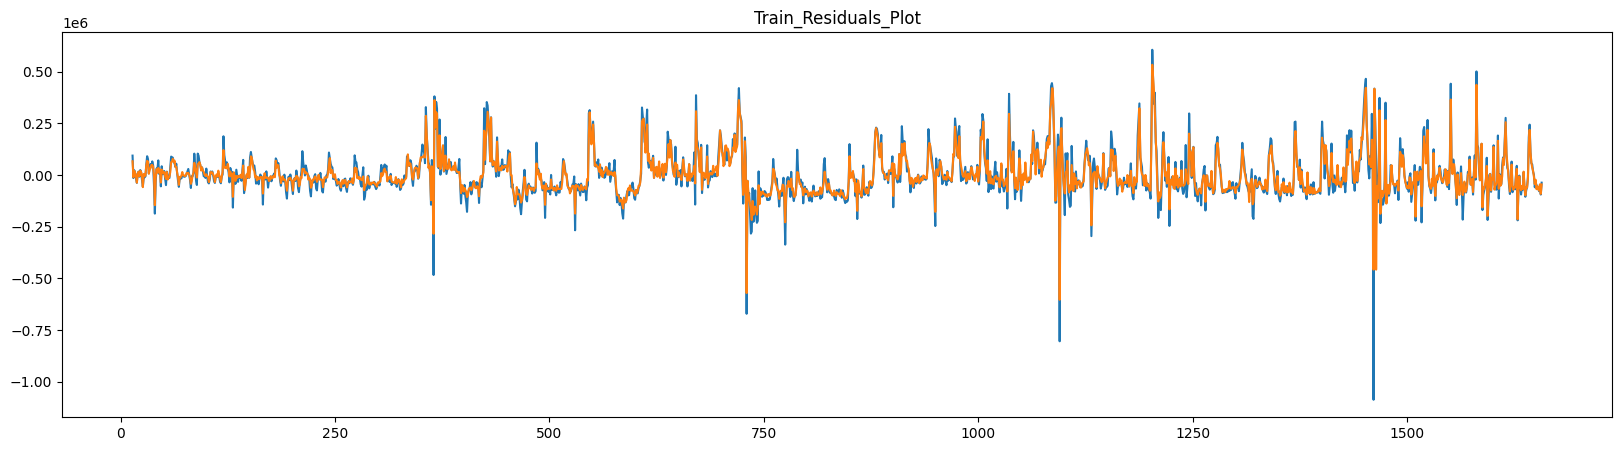

In [23]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(X_train[:,0],  y_train_res) 
plt.plot(X_train[:,0], pred_train_res,)
plt.title('Train_Residuals_Plot')

Text(0.5, 1.0, 'CV_Residuals_Plot')

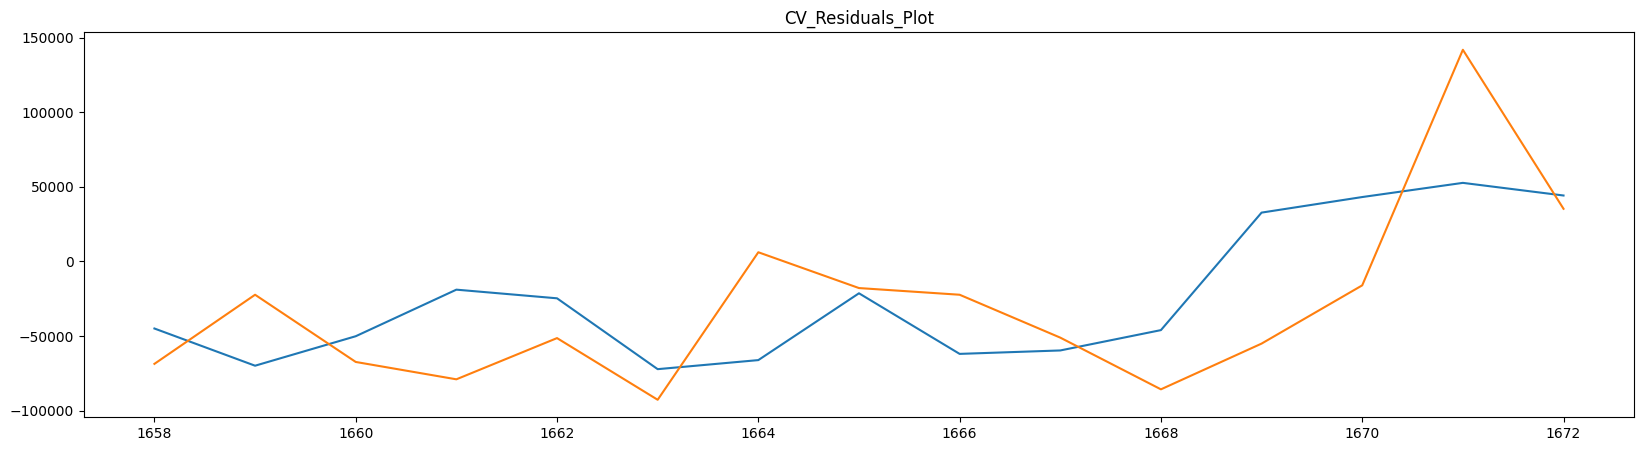

In [24]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(X_CV[:,0], y_CV_res) 
ax.plot(X_CV[:,0], pred_CV_res)
plt.title('CV_Residuals_Plot')